In [1]:
import pickle
from pathlib import Path
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from kaggle.api.kaggle_api_extended import KaggleApi

DROPOFF_DATETIME = 'dropoff_datetime'

PICKUP_DATETIME = 'pickup_datetime'

PICKUP_HOUR_OF_YEAR = 'hour_of_year'

PICKUP_DAY_OF_YEAR = 'day_of_year'

VINCENTY_DISTANCE_KM = 'vin_dist_km'

TRIP_DURATION_MIN = 'trip_dur_min'

HAVERSINE_DISTANCE_KM = 'hav_dist_km'

/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


### Load taxi dataset, unzip and save in taxi_data_raw

In [2]:
def load_taxi_data():
  download_file_name = "nyc-taxi-trip-duration.zip"
  data_dir = Path("data_packages")
  extracted_dir = Path("data")
  csv_path = extracted_dir / "train.csv"
  pkl_path = extracted_dir / "train.pkl"

  zip_path = data_dir / download_file_name

  # Step 0: Fast CSV access via cache (if available)
  if pkl_path.is_file():
    with open(pkl_path, "rb") as f:
      return pickle.load(f)

  # Step 1: Download, only if ZIP is still missing
  if not zip_path.is_file():
    data_dir.mkdir(parents=True, exist_ok=True)
    api = KaggleApi()
    api.authenticate()
    api.competition_download_files("nyc-taxi-trip-duration", path=data_dir)

  # Step 2: Unpack ZIP only if inner ZIPs are missing
  inner_zip_names = {"train.zip", "test.zip", "sample_submission.zip"}
  existing_inner_zips = {z.name for z in data_dir.glob("*.zip")}
  missing_inner_zips = inner_zip_names - existing_inner_zips

  if missing_inner_zips:
    with ZipFile(zip_path, 'r') as outer_zip:
      outer_zip.extractall(data_dir)

  # Step 3: Extract only missing CSVs from inner ZIPs
  extracted_dir.mkdir(parents=True, exist_ok=True)
  for inner_zip in data_dir.glob("*.zip"):
    with ZipFile(inner_zip, 'r') as zip_ref:
      for member in zip_ref.namelist():
        if member.endswith(".csv"):
          target_file = extracted_dir / Path(member).name
          if not target_file.is_file():
            zip_ref.extract(member, path=extracted_dir)

  # Step 4: Load CSV and save pkl cache
  if not csv_path.is_file():
    raise FileNotFoundError(f"'{csv_path}' wurde nicht gefunden – Entpackung fehlgeschlagen.")

  df = pd.read_csv(csv_path)
  with open(pkl_path, "wb") as f:
    pickle.dump(df, f)

  return df


# Anwendung
taxi_data_raw = load_taxi_data()

# Univariat EDA Taxidata

## General Exploration

In [3]:
taxi_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


- 1458644 rows
- 11 columns
- object: id, pickup_datetime, dropoff_datetime, store_and_fwd_flag
- int64: vendor_id, passenger_count, trip_duration
- float64: pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
- no missing values/categories

In [4]:
taxi_data_raw.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

- no NaNs

In [5]:
taxi_data_raw.nunique()

id                    1458644
vendor_id                   2
pickup_datetime       1380222
dropoff_datetime      1380377
passenger_count            10
pickup_longitude        23047
pickup_latitude         45245
dropoff_longitude       33821
dropoff_latitude        62519
store_and_fwd_flag          2
trip_duration            7417
dtype: int64

- id can be used for unique ID
- two unique vendors seems to be allright
- ten unique passengers
- two unique store_and_fwd_flag matches with description

In [6]:
taxi_data_raw[taxi_data_raw.duplicated()]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration


- no duplicated rows

## Exploration of vendor_id

In [7]:
# Vendor ID
taxi_data_raw['vendor_id'].value_counts()

vendor_id
2    780302
1    678342
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

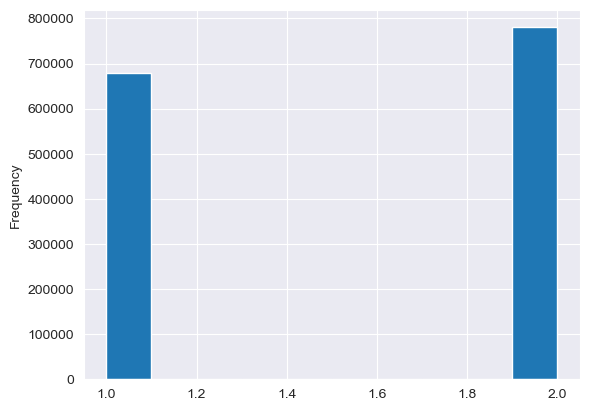

In [8]:
taxi_data_raw['vendor_id'].plot.hist()

- Only two unique values: 1 and 2.
- Frequencies are relatively balanced.
- No missing values or anomalies detected.

## Exploration of pickup_datetime & dropoff_datetime

pickup_datetime

In [9]:
taxi_data_raw[PICKUP_DATETIME] = pd.to_datetime(taxi_data_raw['pickup_datetime'])

- transform object dtype into pd_datetime

In [10]:
taxi_data_raw[PICKUP_DATETIME].astype(str).str.match(
    r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$').all()

np.True_

- check wether the pattern is equal

In [11]:
taxi_data_raw[PICKUP_DATETIME].describe()

count                          1458644
mean     2016-04-01 10:10:24.940037120
min                2016-01-01 00:00:17
25%      2016-02-17 16:46:04.249999872
50%                2016-04-01 17:19:40
75%      2016-05-15 03:56:08.750000128
max                2016-06-30 23:59:39
Name: pickup_datetime, dtype: object

dropoff_datetime

In [12]:
taxi_data_raw[DROPOFF_DATETIME] = pd.to_datetime(taxi_data_raw['dropoff_datetime'])

- transform object dtype into pd_datetime

In [13]:
taxi_data_raw[DROPOFF_DATETIME].astype(str).str.match(
    r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$').all()

np.True_

- check wether the pattern is equal

In [14]:
taxi_data_raw[DROPOFF_DATETIME].describe()

count                          1458644
mean     2016-04-01 10:26:24.432310528
min                2016-01-01 00:03:31
25%         2016-02-17 17:05:32.500000
50%                2016-04-01 17:35:12
75%      2016-05-15 04:10:51.750000128
max                2016-07-01 23:02:03
Name: dropoff_datetime, dtype: object

In [15]:
(taxi_data_raw[DROPOFF_DATETIME] < taxi_data_raw[PICKUP_DATETIME]).sum()

np.int64(0)

- no negative durations

In [16]:
# Basic datetime features
taxi_data_raw['pickup_hour_of_day'] = taxi_data_raw[PICKUP_DATETIME].dt.hour
taxi_data_raw['pickup_day_of_week'] = taxi_data_raw[PICKUP_DATETIME].dt.dayofweek
taxi_data_raw['pickup_month'] = taxi_data_raw[PICKUP_DATETIME].dt.month

# Day of year and hour of year (for merging with weather)
taxi_data_raw[PICKUP_DAY_OF_YEAR] = taxi_data_raw[PICKUP_DATETIME].dt.dayofyear
taxi_data_raw[PICKUP_HOUR_OF_YEAR] = ((taxi_data_raw[PICKUP_DAY_OF_YEAR] - 1) * 24 +
                                      taxi_data_raw['pickup_hour_of_day'])

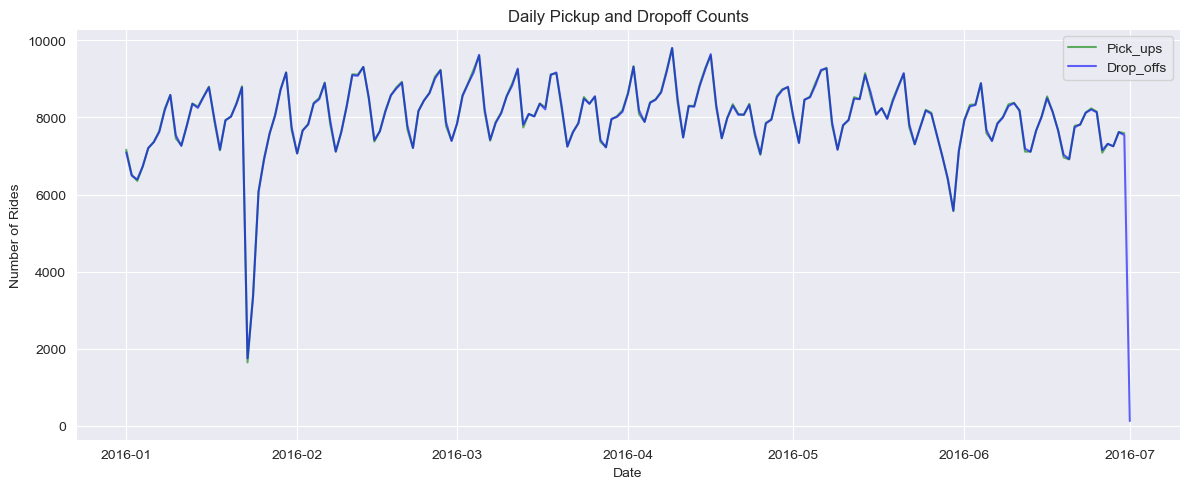

In [17]:
pickup_counts = taxi_data_raw[PICKUP_DATETIME].dt.date.value_counts().sort_index()
dropoff_counts = taxi_data_raw[DROPOFF_DATETIME].dt.date.value_counts().sort_index()

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
pickup_counts.plot(ax=ax, label="Pick_ups", color='green', alpha=0.6)
dropoff_counts.plot(ax=ax, label="Drop_offs", color='blue', alpha=0.6)

ax.set_title("Daily Pickup and Dropoff Counts")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Rides")
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: xlabel='pickup_hour_of_day'>

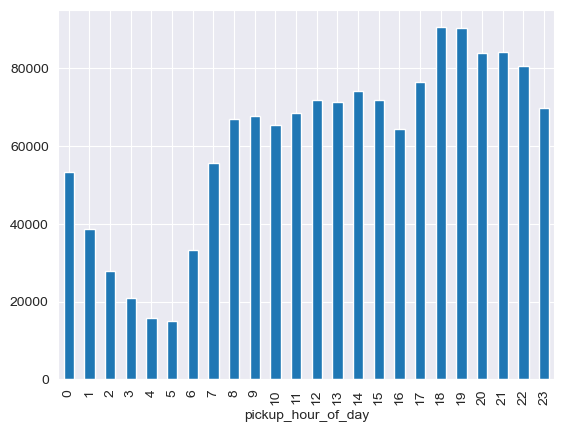

In [18]:
taxi_data_raw["pickup_hour_of_day"].value_counts().sort_index().plot(kind='bar')

- peak from 18 to 22
- trough from 1 to 6

<Axes: xlabel='pickup_day_of_week'>

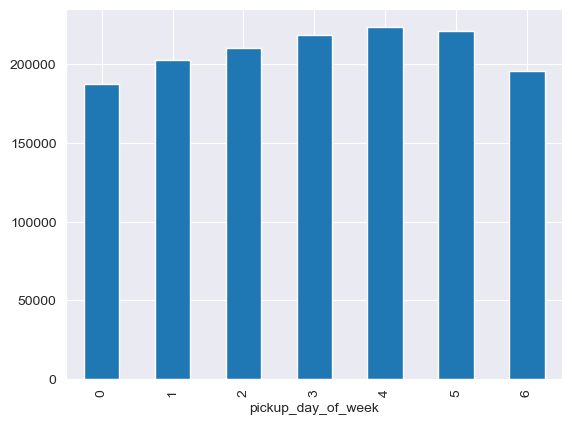

In [19]:
taxi_data_raw['pickup_day_of_week'].value_counts().sort_index().plot(kind='bar')

In [20]:
taxi_data_raw['pickup_day_of_week'].value_counts().sort_index()

pickup_day_of_week
0    187418
1    202749
2    210136
3    218574
4    223533
5    220868
6    195366
Name: count, dtype: int64

- trough on Sunday
- peak on Friday

<Axes: xlabel='pickup_month'>

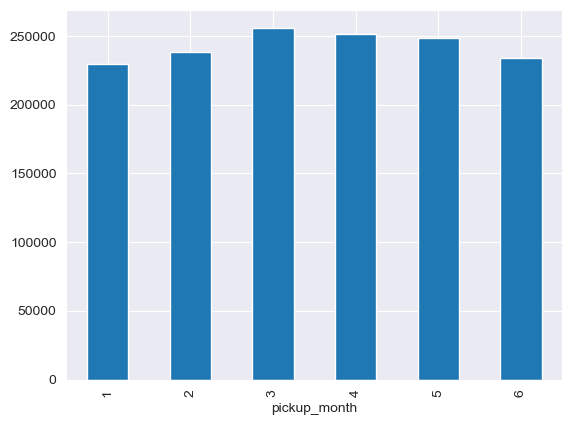

In [21]:
taxi_data_raw['pickup_month'].value_counts().sort_index().plot(kind='bar')

In [22]:
taxi_data_raw['pickup_month'].value_counts().sort_index()

pickup_month
1    229707
2    238300
3    256189
4    251645
5    248487
6    234316
Name: count, dtype: int64

- trough in January
- peak in March

In [23]:
taxi_data_raw.groupby([PICKUP_DATETIME]).size().sort_values(ascending=False).head()

pickup_datetime
2016-03-04 08:07:34    5
2016-01-12 18:48:44    5
2016-06-10 23:17:17    5
2016-02-09 21:03:38    5
2016-05-07 13:18:07    5
dtype: int64

- could be repeated records

<Axes: xlabel='pickup_hour_of_day'>

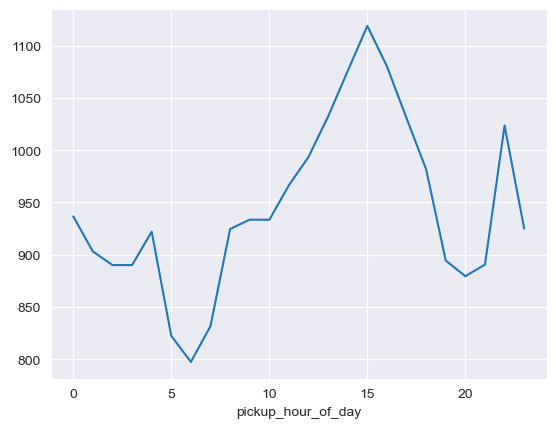

In [24]:
# shows the average trip duration per pickup hour across a 24-hour day
taxi_data_raw.groupby(taxi_data_raw['pickup_hour_of_day'])['trip_duration'].mean().plot()

- aligns with expected rush hour effects

## Exploration of passenger_count

Findings
- The majority of trips have 1 passenger; distribution is heavily right-skewed
- Edge values observed: 60 trips with 0 passengers, and very few with 7–9 passengers
- These edge values are likely invalid or extremely rare
- Trips with 0 passengers show the highest average trip duration, which is implausible and suggests data entry or system error
- Passenger counts 7–9 are extremely rare and may suffer from sampling bias or logging issues
- These edge cases collectively make up a very small share of the data (<0.01%)

In [25]:
taxi_data_raw["passenger_count"].describe()

count    1.458644e+06
mean     1.664530e+00
std      1.314242e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

In [26]:
# Passenger count
taxi_data_raw['passenger_count'].value_counts().sort_index()

passenger_count
0         60
1    1033540
2     210318
3      59896
4      28404
5      78088
6      48333
7          3
8          1
9          1
Name: count, dtype: int64

- 60 with passenger count 0
- 5 with passenger count > 6

<Axes: xlabel='passenger_count'>

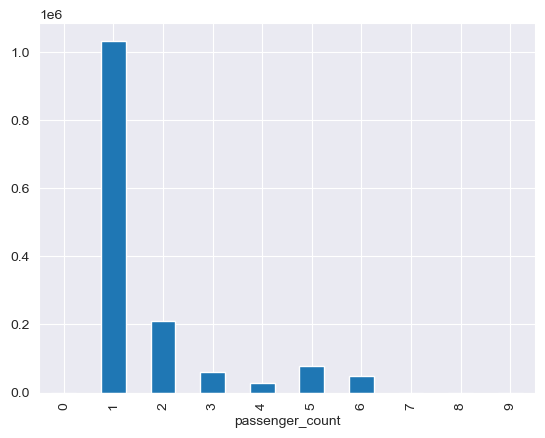

In [27]:
taxi_data_raw['passenger_count'].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='passenger_count'>

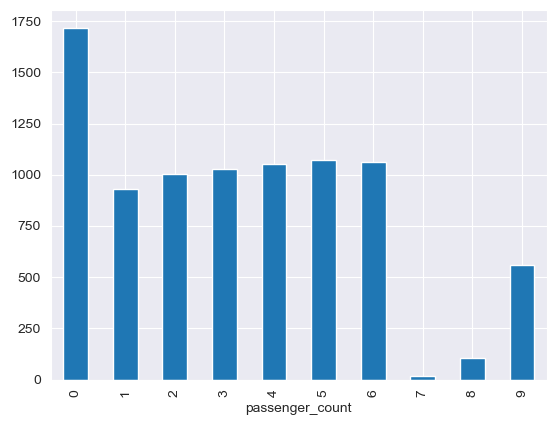

In [28]:
taxi_data_raw.groupby('passenger_count')['trip_duration'].mean().plot(kind='bar')

- Passenger count = 0 has the highest average trip duration, which is not plausible, indicating likely data entry or logging errors

<Axes: xlabel='pickup_hour_of_day'>

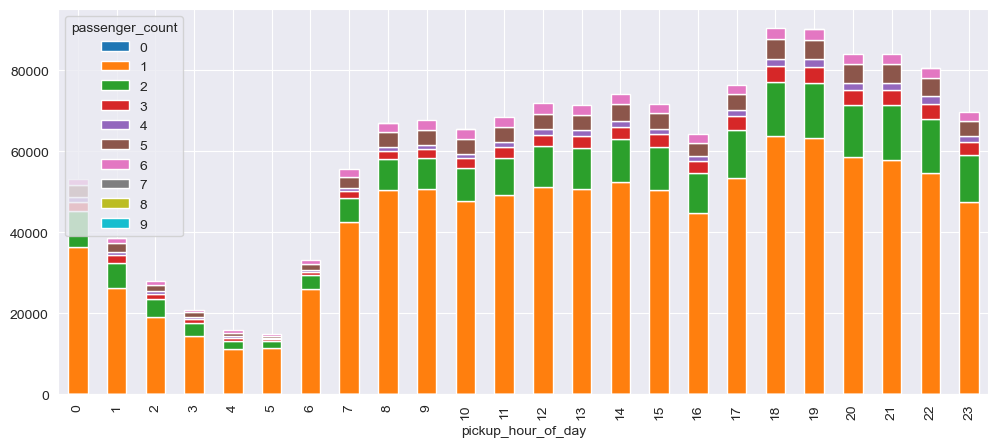

In [29]:
(pd.crosstab(taxi_data_raw['pickup_hour_of_day'], taxi_data_raw['passenger_count']).plot(
    kind='bar', stacked=True, figsize=(12, 5)))

- Passenger count = 1 dominates at all hours
- Group trips (2–4 passengers) are more frequent in the evening and late night

In [30]:
edge_cases = taxi_data_raw['passenger_count'].isin([0, 7, 8, 9])
edge_cases.mean()

np.float64(4.4561935605946344e-05)

- 0.0045% of trips are likely outliers or errors

In [31]:
# View rows with passenger_count == 0
zero_passenger_trips = taxi_data_raw[taxi_data_raw['passenger_count'] == 0]

zero_passenger_trips[[PICKUP_DATETIME, DROPOFF_DATETIME, 'trip_duration']].describe()

,pickup_datetime,dropoff_datetime,trip_duration
count,60,60,60.000000
mean,2016-03-15 22:50:02.650000128,2016-03-15 23:18:41.083333376,1718.433333
min,2016-01-01 05:01:32,2016-01-01 05:01:36,1.000000
25%,2016-02-01 01:11:45.249999872,2016-02-01 01:12:16.750000128,6.750000
50%,2016-03-11 11:06:05.500000,2016-03-11 11:24:22.500000,20.500000
75%,2016-05-06 01:24:55.500000,2016-05-06 01:25:09,92.250000
max,2016-06-13 05:59:07,2016-06-13 05:59:16,85901.000000
std,NaN,NaN,11072.157098


## Explore pickup_longitude, pickup_latitude & dropoff_longitude, dropoff_latitude

In [32]:
# Summary statistics for coordinates
taxi_data_raw[
  ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].describe()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,4.075092e+01,-7.397349e+01,4.075180e+01,-7.397342e+01
std,3.288119e-02,7.090186e-02,3.589056e-02,7.064327e-02
min,3.435970e+01,-1.219333e+02,3.218114e+01,-1.219333e+02
25%,4.073735e+01,-7.399187e+01,4.073588e+01,-7.399133e+01
50%,4.075410e+01,-7.398174e+01,4.075452e+01,-7.397975e+01
75%,4.076836e+01,-7.396733e+01,4.076981e+01,-7.396301e+01
max,5.188108e+01,-6.133553e+01,4.392103e+01,-6.133553e+01


In [33]:
taxi_data_raw[
  (taxi_data_raw['pickup_latitude'] < 40.47) | (taxi_data_raw['pickup_latitude'] > 41.0) |
  (taxi_data_raw['dropoff_latitude'] < 40.47) | (taxi_data_raw['dropoff_latitude'] > 41.0) |
  (taxi_data_raw['pickup_longitude'] < -74.3) | (taxi_data_raw['pickup_longitude'] > -73.6) |
  (taxi_data_raw['dropoff_longitude'] < -74.3) | (taxi_data_raw['dropoff_longitude'] > -73.6)]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour_of_day,pickup_day_of_week,pickup_month,day_of_year,hour_of_year
115,id2358953,2,2016-06-27 00:31:28,2016-06-27 01:06:44,1,-73.870819,40.773739,-73.857498,41.017811,N,2116,0,0,6,179,4272
991,id1859156,1,2016-02-17 00:54:13,2016-02-17 01:36:27,3,-73.969254,40.754047,-73.593582,41.043865,N,2534,0,2,2,48,1128
1101,id3913560,2,2016-01-11 22:48:55,2016-01-11 23:40:20,2,-74.012657,40.702179,-74.307762,40.567341,N,3085,22,0,1,11,262
9565,id0304778,1,2016-02-23 20:38:44,2016-02-23 21:19:17,1,-73.982925,40.761841,-74.379631,40.745274,N,2433,20,1,2,54,1292
13006,id3022813,1,2016-06-15 18:02:41,2016-06-15 18:03:18,1,-73.558289,40.781223,-73.558281,40.781227,N,37,18,2,6,167,4002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449228,id2148312,2,2016-04-23 22:44:36,2016-04-23 23:31:57,1,-73.790451,40.646904,-73.837021,41.061226,N,2841,22,5,4,114,2734
1449384,id3101192,1,2016-05-17 20:43:33,2016-05-17 22:13:12,2,-73.979401,40.752388,-73.872871,41.040192,N,5379,20,1,5,138,3308
1450700,id1292498,1,2016-06-23 07:02:07,2016-06-23 08:28:12,1,-73.782013,40.644894,-73.774452,41.031044,N,5165,7,3,6,175,4183
1454301,id1367595,2,2016-04-09 01:38:09,2016-04-09 02:14:52,1,-74.047142,40.789986,-74.010872,41.112366,N,2203,1,5,4,100,2377


- Some trip coordinates lie outside NYC bounds
- Some points lie far outside the visible city bounds — likely due to GPS glitches or data corruption.

In [34]:
taxi_data_raw['pickup_longitude'].map(lambda x: str(x).endswith('000')).mean()

np.float64(0.0)

In [35]:
taxi_data_raw['pickup_latitude'].map(lambda x: str(x).endswith('000')).mean()

np.float64(0.0)

In [36]:
taxi_data_raw['dropoff_latitude'].map(lambda x: str(x).endswith('000')).mean()

np.float64(0.0)

In [37]:
taxi_data_raw['dropoff_longitude'].map(lambda x: str(x).endswith('000')).mean()

np.float64(0.0)

- no rounding issues

### Geographic distribution

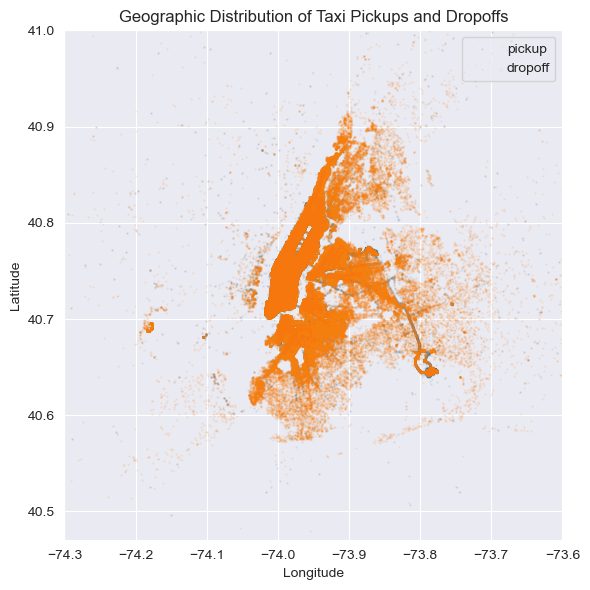

In [38]:
# Scatterplot of pickup and dropoff locations
plt.figure(figsize=(6, 6))
plt.scatter(taxi_data_raw['pickup_longitude'], taxi_data_raw['pickup_latitude'], s=0.5, alpha=0.1,
            label='pickup')
plt.scatter(taxi_data_raw['dropoff_longitude'], taxi_data_raw['dropoff_latitude'], s=0.5, alpha=0.1,
            label='dropoff')
plt.xlim(-74.3, -73.6)
plt.ylim(40.47, 41.0)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='upper right')
plt.title("Geographic Distribution of Taxi Pickups and Dropoffs")
plt.grid(True)
plt.tight_layout()
plt.show()

- Most pickups and dropoffs are located within the NYC area (Manhattan, Brooklyn, Queens).
- Clear density clusters appear around Midtown and Downtown Manhattan.

In [39]:
taxi_data_raw[
  (taxi_data_raw['pickup_latitude'].round(5) == taxi_data_raw['dropoff_latitude'].round(5)) &
  (taxi_data_raw['pickup_longitude'].round(5) == taxi_data_raw['dropoff_longitude'].round(5)) &
  (taxi_data_raw['trip_duration'] > 300)  # more than 5 minutes
  ]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour_of_day,pickup_day_of_week,pickup_month,day_of_year,hour_of_year
291,id0924324,2,2016-05-10 18:07:52,2016-05-10 18:26:21,2,-73.959068,40.775661,-73.959068,40.775661,N,1109,18,1,5,131,3138
407,id1145809,2,2016-05-16 23:15:13,2016-05-16 23:31:00,6,-73.808487,40.687336,-73.808487,40.687336,N,947,23,0,5,137,3287
702,id3499387,1,2016-01-25 19:45:12,2016-01-25 19:54:52,1,-73.786720,40.647041,-73.786720,40.647041,N,580,19,0,1,25,595
2609,id1992673,2,2016-03-02 20:10:41,2016-03-02 20:30:53,5,-73.875313,40.773682,-73.875313,40.773682,N,1212,20,2,3,62,1484
3014,id3206922,2,2016-04-24 18:38:34,2016-04-24 18:48:32,1,-73.985168,40.736259,-73.985168,40.736259,N,598,18,6,4,115,2754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455304,id1799905,2,2016-02-17 08:08:40,2016-02-17 08:16:49,1,-73.981995,40.759571,-73.981995,40.759571,N,489,8,2,2,48,1136
1456135,id1441158,1,2016-03-17 21:53:37,2016-03-17 22:01:16,2,-73.978439,40.736889,-73.978439,40.736889,N,459,21,3,3,77,1845
1456399,id0618137,2,2016-02-17 08:57:04,2016-02-17 09:18:28,1,-73.978859,40.756721,-73.978859,40.756721,N,1284,8,2,2,48,1136
1456989,id2595295,2,2016-03-12 07:37:16,2016-03-12 07:46:42,1,-73.984848,40.728222,-73.984848,40.728222,N,566,7,5,3,72,1711


- implausible values

## Explore store_and_fwd_flag

In [40]:
taxi_data_raw['store_and_fwd_flag'].value_counts(normalize=True)

store_and_fwd_flag
N    0.994485
Y    0.005515
Name: proportion, dtype: float64

<Axes: xlabel='store_and_fwd_flag'>

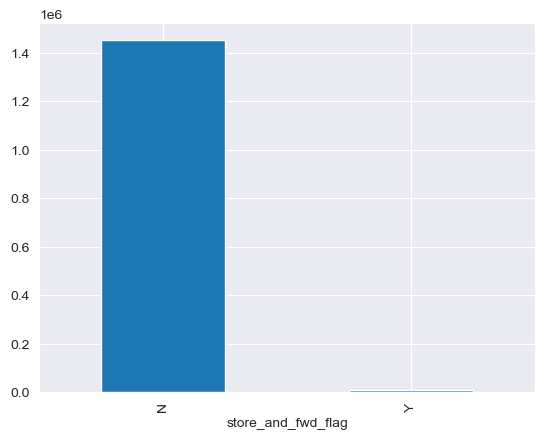

In [41]:
taxi_data_raw['store_and_fwd_flag'].value_counts().sort_index().plot(kind='bar')

- store_and_fwd_flag = 'Y' is rare and likely not predictive on its own

## Exploration of trip_duration

In [42]:
# Summary statistics for trip duration
taxi_data_raw['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

In [43]:
# Check for extreme trip durations
taxi_data_raw[taxi_data_raw['trip_duration'] > 3 * 3600]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour_of_day,pickup_day_of_week,pickup_month,day_of_year,hour_of_year
531,id3307903,2,2016-02-20 04:03:06,2016-02-21 03:33:00,3,-74.008102,40.741489,-74.009956,40.714611,N,84594,4,5,2,51,1204
1134,id1091477,2,2016-05-07 18:36:22,2016-05-08 18:32:11,1,-73.990242,40.750919,-73.976280,40.750889,N,86149,18,5,5,128,3066
1865,id3431345,2,2016-06-07 12:58:48,2016-06-08 12:58:00,6,-73.954956,40.777649,-73.981033,40.743713,N,86352,12,1,6,159,3804
3442,id1487069,2,2016-02-13 00:21:49,2016-02-14 00:19:05,1,-73.968590,40.799217,-73.979584,40.784714,N,86236,0,5,2,44,1032
4172,id3674870,2,2016-03-18 11:54:20,2016-03-19 11:34:17,1,-73.989090,40.736992,-73.972336,40.751511,N,85197,11,4,3,78,1859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455097,id2798196,2,2016-03-20 03:51:36,2016-03-21 00:00:00,2,-73.969299,40.757301,-73.870277,40.709808,N,72504,3,6,3,80,1899
1456458,id2055880,2,2016-02-08 19:11:31,2016-02-09 19:08:44,3,-73.973282,40.760792,-73.988518,40.764210,N,86233,19,0,2,39,931
1457207,id1910950,2,2016-06-08 16:29:12,2016-06-09 16:11:03,1,-73.958061,40.800869,-73.964119,40.805515,N,85311,16,2,6,160,3832
1457752,id1215198,2,2016-02-02 11:31:10,2016-02-03 11:29:44,6,-73.972069,40.794220,-73.961014,40.806728,N,86314,11,1,2,33,779


In [44]:
taxi_data_raw[taxi_data_raw['trip_duration'] < 60]  # < 1 minute

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour_of_day,pickup_day_of_week,pickup_month,day_of_year,hour_of_year
72,id1510700,2,2016-02-20 21:58:13,2016-02-20 21:59:10,1,-73.958397,40.772629,-73.955132,40.774242,N,57,21,5,2,51,1221
323,id2954399,1,2016-06-27 11:22:37,2016-06-27 11:23:17,1,-74.001030,40.756653,-74.000999,40.756626,N,40,11,0,6,179,4283
842,id3263580,2,2016-05-21 12:46:46,2016-05-21 12:46:49,2,-73.782372,40.648766,-73.782372,40.648746,N,3,12,5,5,142,3396
853,id2730154,2,2016-03-29 22:39:46,2016-03-29 22:40:44,5,-73.982201,40.731812,-73.979950,40.734814,N,58,22,1,3,89,2134
1107,id0729156,2,2016-06-23 13:36:48,2016-06-23 13:36:50,3,-73.827660,40.716175,-73.822113,40.711452,N,2,13,3,6,175,4189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458044,id3200588,2,2016-03-12 01:35:35,2016-03-12 01:35:42,1,-74.007378,40.739441,-74.007378,40.739449,N,7,1,5,3,72,1705
1458085,id1326136,2,2016-05-21 12:07:11,2016-05-21 12:07:28,1,-73.978935,40.762463,-73.977654,40.762012,N,17,12,5,5,142,3396
1458140,id0175875,1,2016-03-22 06:18:10,2016-03-22 06:18:47,1,-73.991325,40.744934,-73.989388,40.748024,N,37,6,1,3,82,1950
1458544,id3958653,1,2016-06-16 15:10:11,2016-06-16 15:10:49,1,-73.956459,40.767231,-73.956589,40.767269,N,38,15,3,6,168,4023


- Several trips have a duration longer than 2 hours, which is highly unlikely for intra-city NYC taxi rides. A few trips are also shorter than 1 minute, which may indicate errors or missing data.

<Axes: xlabel='trip_duration'>

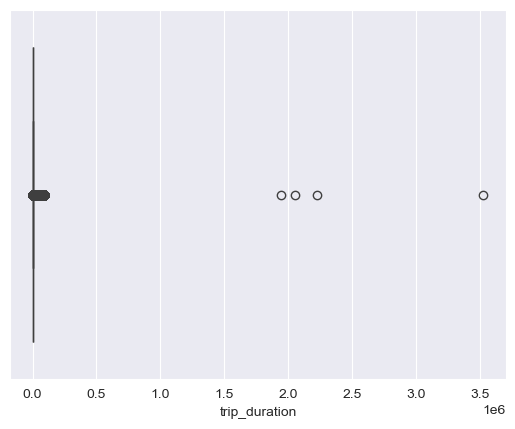

In [45]:
import seaborn as sns

sns.boxplot(x=taxi_data_raw['trip_duration'])

In [46]:
# Trip duration in minutes
taxi_data_raw[TRIP_DURATION_MIN] = taxi_data_raw['trip_duration'] / 60

### Haversine

In [47]:
def haversine(lat1, lon1, lat2, lon2):
  r = 6378.135  # Earth's radius in km

  # Convert latitude and longitude to radians
  lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

  # Calculate the difference between the two coordinates
  dlat = lat2 - lat1
  dlon = lon2 - lon1

  # Apply the haversine formula
  a = (np.sin(dlat / 2)) ** 2 + (np.cos(lat1) * np.cos(lat2)) * (np.sin(dlon / 2)) ** 2
  c = 2 * r * np.arcsin(np.sqrt(a))

  # Return the distance
  return c

In [48]:
# Apply haversine to the dataset
taxi_data_raw[HAVERSINE_DISTANCE_KM] = haversine(
    taxi_data_raw['pickup_latitude'], taxi_data_raw['pickup_longitude'],
    taxi_data_raw['dropoff_latitude'], taxi_data_raw['dropoff_longitude']
)

<Axes: xlabel='hav_dist_km', ylabel='trip_dur_min'>

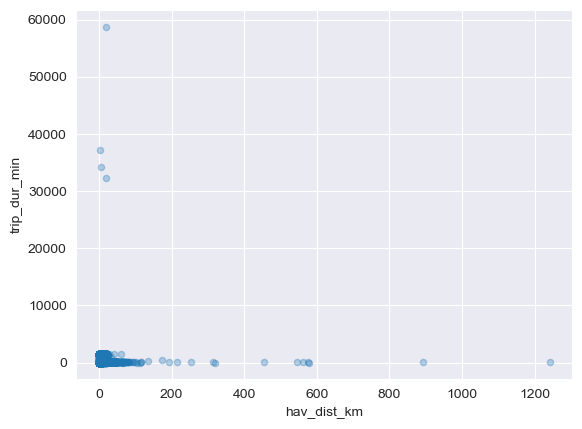

In [49]:
taxi_data_raw.plot.scatter(x=HAVERSINE_DISTANCE_KM, y=TRIP_DURATION_MIN, alpha=0.3)

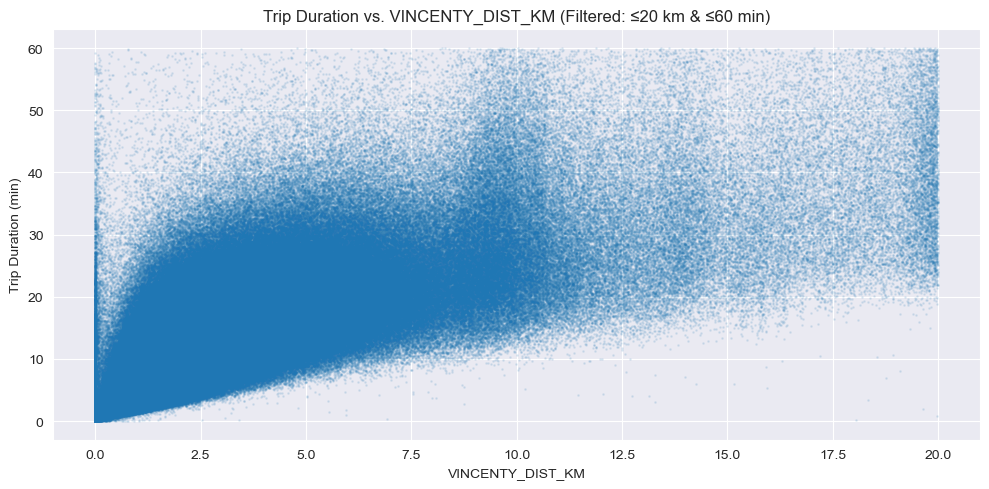

In [50]:
# Filter for clearer visualization
filtered_data = taxi_data_raw[
  (taxi_data_raw[HAVERSINE_DISTANCE_KM] <= 20) &
  (taxi_data_raw[TRIP_DURATION_MIN] <= 60)
  ]

# Plot
plt.figure(figsize=(10, 5))
plt.scatter(filtered_data[HAVERSINE_DISTANCE_KM], filtered_data[TRIP_DURATION_MIN], alpha=0.1, s=1)
plt.xlabel("VINCENTY_DIST_KM")
plt.ylabel("Trip Duration (min)")
plt.title("Trip Duration vs. VINCENTY_DIST_KM (Filtered: ≤20 km & ≤60 min)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Vincenty

In [51]:
def vincenty(lat1, lon1, lat2, lon2):
  # Convert latitude and longitude to radians
  lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

  # Calculate the difference between the two coordinates
  dlat = lat2 - lat1
  dlon = lon2 - lon1

  # Apply the Vincenty formula
  a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
  c = 2 * np.atan2(np.sqrt(a), np.sqrt(1 - a))

  # Calculate the ellipsoid parameters
  f = 1 / 298.257223563  # flattening of the Earth's ellipsoid
  b = (1 - f) * 6378.135  # semi-minor axis of the Earth's ellipsoid

  # Return the distance
  return c * b

In [52]:
# Apply haversine to the dataset
taxi_data_raw[VINCENTY_DISTANCE_KM] = vincenty(
    taxi_data_raw['pickup_latitude'], taxi_data_raw['pickup_longitude'],
    taxi_data_raw['dropoff_latitude'], taxi_data_raw['dropoff_longitude']
)

<Axes: xlabel='vin_dist_km', ylabel='trip_dur_min'>

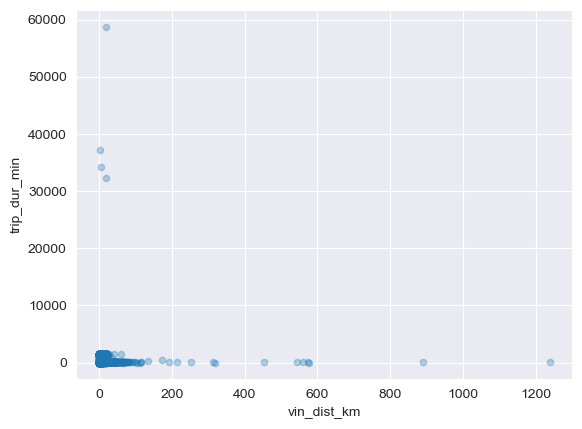

In [53]:
taxi_data_raw.plot.scatter(x=VINCENTY_DISTANCE_KM, y=TRIP_DURATION_MIN, alpha=0.3)

- Long durations at very short distances
- Long distances with short durations

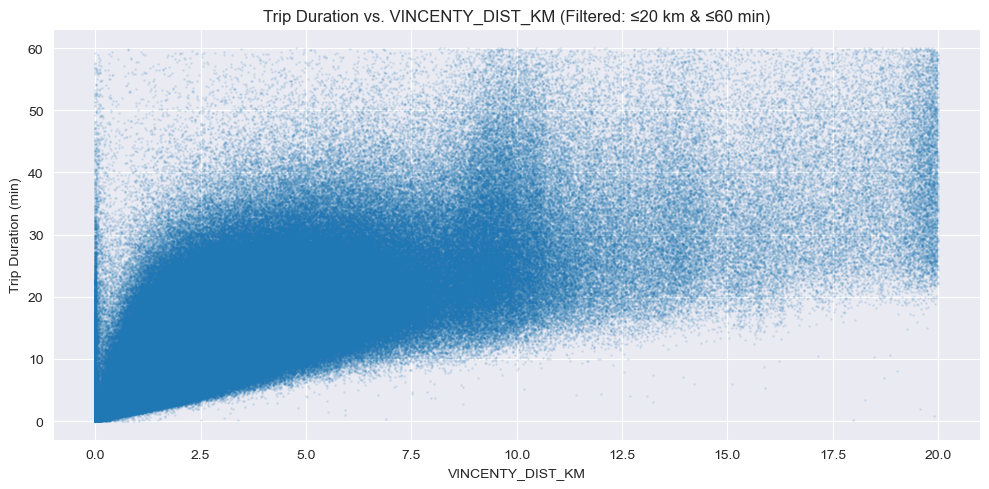

In [54]:
# Filter for clearer visualization
filtered_data = taxi_data_raw[
  (taxi_data_raw[VINCENTY_DISTANCE_KM] <= 20) &
  (taxi_data_raw[TRIP_DURATION_MIN] <= 60)
  ]

# Plot
plt.figure(figsize=(10, 5))
plt.scatter(filtered_data[VINCENTY_DISTANCE_KM], filtered_data[TRIP_DURATION_MIN], alpha=0.1, s=1)
plt.xlabel("VINCENTY_DIST_KM")
plt.ylabel("Trip Duration (min)")
plt.title("Trip Duration vs. VINCENTY_DIST_KM (Filtered: ≤20 km & ≤60 min)")
plt.grid(True)
plt.tight_layout()
plt.show()

- For trips under ~2 km, durations vary widely
- Some points still lie far above the trend line

In [ ]:
from geopy.distance import geodesic

# Apply geodesic row-wise
taxi_data_raw['geodesic_km'] = taxi_data_raw.apply(
    lambda row: geodesic(
        (row['pickup_latitude'], row['pickup_longitude']),
        (row['dropoff_latitude'], row['dropoff_longitude'])
    ).kilometers,
    axis=1
)

In [ ]:
from geopy.distance import great_circle

# Apply geodesic row-wise
taxi_data_raw['great_circle_km'] = taxi_data_raw.apply(
    lambda row: great_circle(
        (row['pickup_latitude'], row['pickup_longitude']),
        (row['dropoff_latitude'], row['dropoff_longitude'])
    ).kilometers,
    axis=1
)

In [ ]:
# Histogram (capped at 100 minutes for clarity)
plt.figure(figsize=(8, 4))
plt.hist(taxi_data_raw[TRIP_DURATION_MIN], bins=100, range=(0, 100), edgecolor='black')
plt.title("Distribution of Trip Duration (minutes)")
plt.xlabel("Trip Duration [min]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Log-transformed trip duration
taxi_data_raw['trip_duration_log'] = np.log1p(taxi_data_raw['trip_duration'])

plt.figure(figsize=(8, 4))
plt.hist(taxi_data_raw['trip_duration_log'], bins=100, edgecolor='black')
plt.title("Log-Transformed Trip Duration")
plt.xlabel("log(1 + trip_duration [s])")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

- log1p(trip_duration) helps stabilize variance, handle skewness, and improve model performance

# Save Taxi Data

In [ ]:
taxi_data_raw.to_csv("data/taxi_data_clean.csv", index=False)